In [4]:
import os, sys
sys.path.insert(0, '..')

In [5]:
from jax.scipy.special import logsumexp
import matplotlib.pyplot as plt
from functools import partial
import jax.numpy as jnp
from jax import random
import seaborn as sns
import pandas as pd
from new import *
import itertools
import jax

%config InlineBackend.figure_format='retina'
plt.rcParams.update({'axes.linewidth'    : 0.4,
                     'ytick.major.width' : 0.4,
                     'ytick.minor.width' : 0.4,
                     'xtick.major.width' : 0.4,
                     'xtick.minor.width' : 0.4,
                     'xtick.major.size'  : 4,
                     'xtick.minor.size'  : 2,
                     'ytick.major.size'  : 4,
                     'ytick.minor.size'  : 2,
                     'xtick.minor.visible' : 'True',
                     'ytick.minor.visible' : 'True',
                     'xtick.labelsize': 8, 
                     'ytick.labelsize': 8,
                     'axes.labelsize' : 8,
                     'font.family': 'Serif',
                     'figure.figsize': (3.5, 3.33),
                     'figure.dpi' : 200,
                     'ytick.right': 'True',
                     'xtick.top'  : 'True',
                     'ytick.direction': 'in',
                     'xtick.direction': 'in',
                     'axes.spines.top': 'True',
                     'axes.grid': 'False',
                     'grid.linestyle': '--',
                     'grid.linewidth': 0.10
                    })
sns.set_palette('deep')

In [6]:
def generate_grid(
    key = random.key(42),
    num_epochs = 10,
    num_stars = 2000,
    mass = 0.8,
    log_g = 2.0,
    binary_fraction = 1.0,
    dt = 100,
    mean_vlos = 0,
    dispersion_vlos = 1,
    noise = 0.1,
    obs = True
    ):
    all_masses = jnp.array([mass]*num_stars)
    all_log_g = jnp.array([log_g]*num_stars)

    binary_mask   = random.bernoulli(key=key,p=binary_fraction,shape=all_masses.shape)
    binary_masses = all_masses[binary_mask]
    binary_log_g  = all_log_g[binary_mask]

    state = generate_orbit_state(key=key,masses=binary_masses,log_g=binary_log_g)
    vr = []
    dt_days=jnp.array([dt]*num_epochs)

    for i in range(num_epochs):
        state = binary_step(params=state.params,dt_days=dt_days[i])
        vr.append(state.v_r)
    vr = jnp.array(vr).T

    v_los = mean_vlos + dispersion_vlos*random.normal(key,shape=all_masses.shape)
    v_los = jnp.repeat(v_los[:, jnp.newaxis], num_epochs, axis=-1)
    v_los_noise = noise*random.normal(key,shape=v_los.shape)
    binary_mask_expanded = jnp.repeat(binary_mask[:, jnp.newaxis], num_epochs, axis=-1)
    vr = jnp.place(arr=jnp.zeros(v_los.shape), mask=binary_mask_expanded, vals=vr, inplace=False)
    v_los_total = v_los + v_los_noise + vr
    if obs:
        return v_los_total, binary_mask
    return v_los_total

def calculate_log_p_H0(observed_velocities, sigma):
    """Calculate log likelihood under H0 (single star) for each star."""
    n = observed_velocities.shape[1]
    sample_mean = jnp.mean(observed_velocities, axis=1)
    sample_var = jnp.var(observed_velocities, axis=1, ddof=1)
    term1 = - (n - 1)/2 * jnp.log(2 * jnp.pi)
    term2 = - (n - 1) * jnp.log(sigma)
    term3 = - 0.5 * jnp.log(n)
    term4 = - (n - 1) * sample_var / (2 * sigma**2)
    log_p_H0 = term1 + term2 + term3 + term4
    return log_p_H0

def calculate_log_p_H1(observed_velocities, true_binary_sequences, sigma):
    """Log likelihood under H1 (binary star)."""
    M = true_binary_sequences.shape[0]
    differences = observed_velocities[:, jnp.newaxis, :] - true_binary_sequences[jnp.newaxis, :, :]
    sum_sq = jnp.sum((differences / sigma)**2, axis=2)  # Shape: (2000, M)
    log_likelihoods = -0.5 * sum_sq - observed_velocities.shape[1] * jnp.log(sigma) - 0.5 * observed_velocities.shape[1] * jnp.log(2 * jnp.pi)
    log_p_H1 = logsumexp(log_likelihoods, axis=1) - jnp.log(M)
    return log_p_H1

param_grid = {
    "m": [0.8],
    "log_g": [1.5, 3.0, 4.0],
    "n_obs": [3, 5, 10, 20, 30],
    "baseline": [0.5, 1.0, 2.0, 3.0],
    "sigma_obs": [0.1, 0.5, 1.0],
    "threshold": [0.9997]
}

param_combinations = list(itertools.product(*param_grid.values()))
param_names = list(param_grid.keys())

    
model_grid = generate_grid(key=grid_key, 
                           mass=m,
                           log_g=log_g,
                           num_epochs=n_obs,
                           dt=dt_day,
                           obs=False)
obs, true_binaries = generate_grid(key=obs_key,
                                           mass=m,
                                           log_g=log_g, 
                                           num_epochs=n_obs,
                                           dt=dt_day,
                                           noise=sigma_obs,
                                           binary_fraction=0.5,
                                           obs=True)
    
def run_experiment(params, grid_key, obs_key):
    """Run one experiment for a given parameter set."""
    m, log_g, n_obs, baseline, sigma_obs, threshold = params
    n_obs = int(n_obs) 
    dt_day = baseline / n_obs * 365.25
    log_p_H0 = calculate_log_p_H0(obs, sigma_obs)
    log_p_H1 = calculate_log_p_H1(obs, model_grid, sigma_obs)
   
    log_odds = log_p_H1 - log_p_H0
    posterior_prob_H1 = 1 / (1 + jnp.exp(-log_odds))
    predicted = posterior_prob_H1 > threshold

    TP = jnp.sum((predicted == 1) & (true_binaries == 1))
    return TP.item()/true_binaries.sum().item()

def main(key=random.PRNGKey(42)):
    grid_key, obs_key = random.split(key, 2)
    param_array = jnp.array(param_combinations)
    results = []
    for i,p in enumerate(param_array):
        TP = run_experiment(p, grid_key, obs_key)
        results.append(dict(zip(param_names, p)) | {'TP': TP})
    return results 

results = main()

NameError: name 'grid_key' is not defined

In [ ]:
df = pd.DataFrame(results)
df['dt_yrs'] = df['baseline']

In [ ]:
df.to_csv('detect_results.data', sep=r' ')

In [ ]:
df = df.astype(float)
# df.TP = df.TP/df.tot

really bad plotting code do not judge

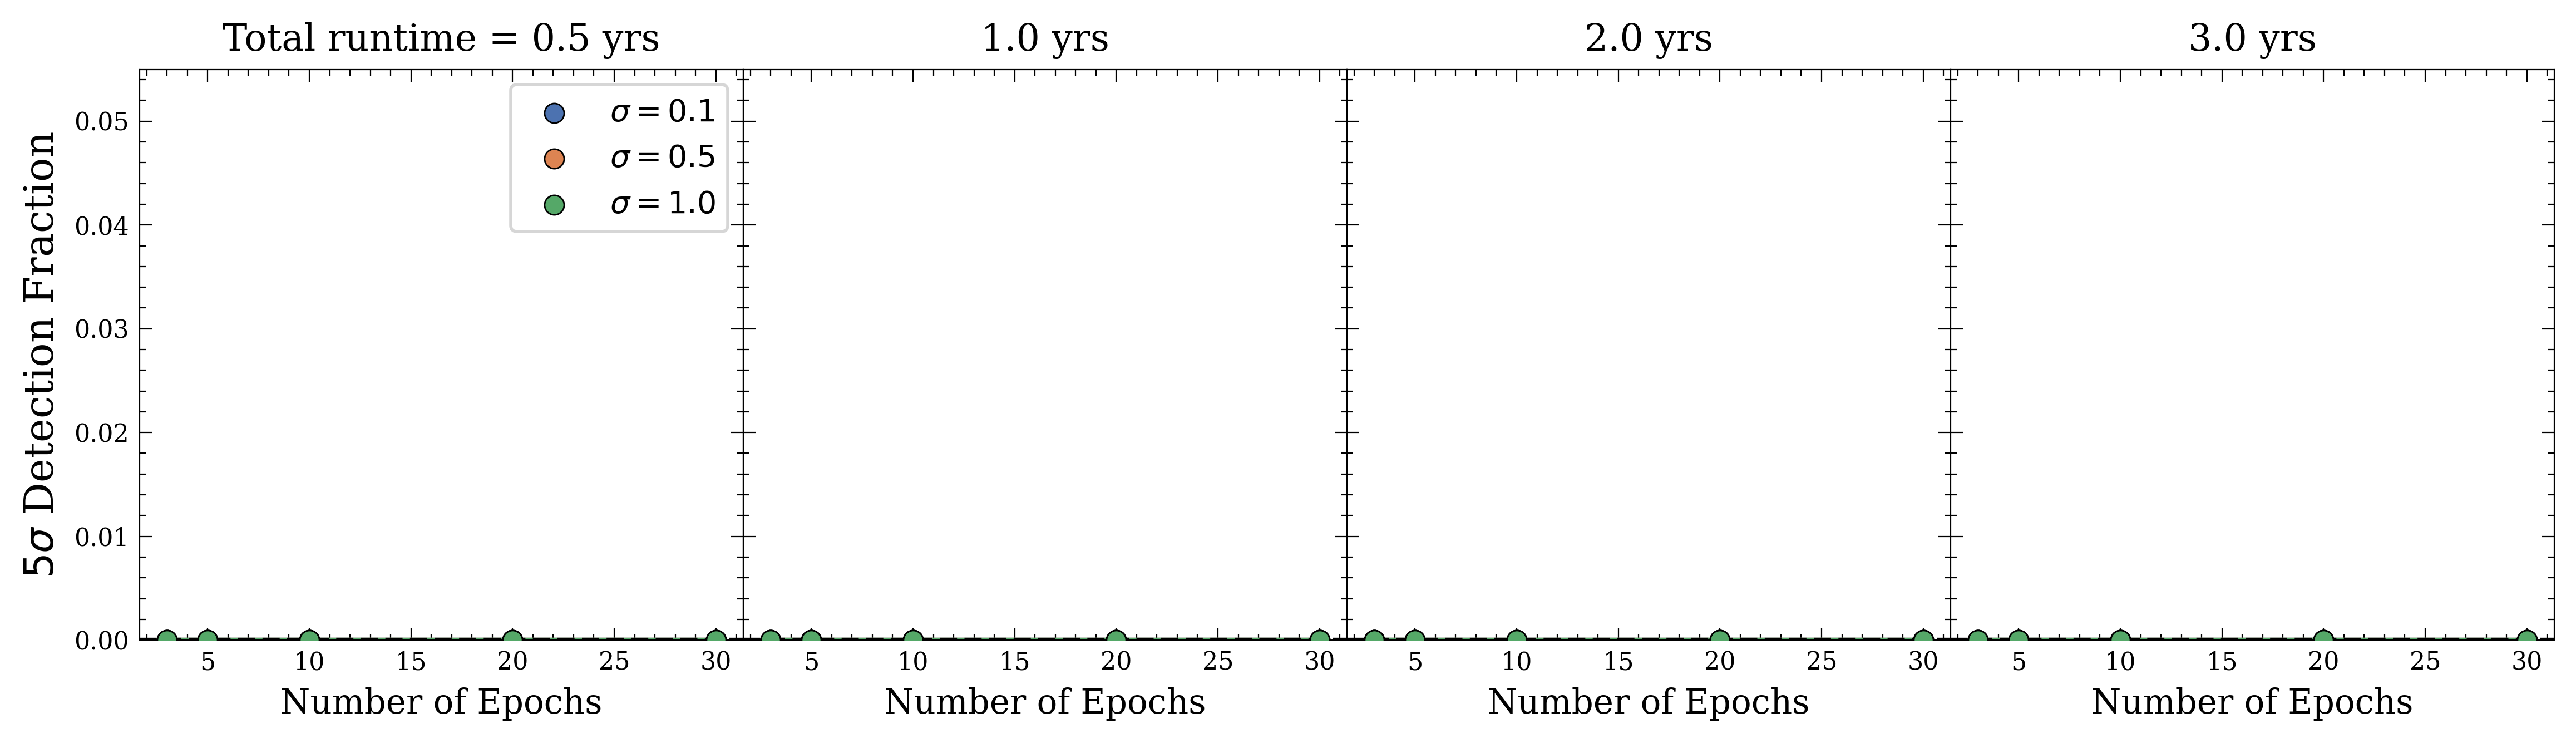

In [213]:
import seaborn as sns
param_grid = {
    "log_g": [1.5, 3.0, 4.0],
    "n_obs": [3, 5, 10, 30],
    "dt_yrs": [0.5, 1.0, 2.0, 3.0],
    "sigma_obs": [0.1, 0.5, 1.0],
}

fig, axs = plt.subplots(1,4, figsize=(4*3.5,3.33), sharey=True)
plt.subplots_adjust(wspace=0.0)

axs[0].scatter(df[(df.log_g==1.5) & (df.dt_yrs==0.5) & (df['sigma_obs']!=0.5) & (df['sigma_obs']!=1.0)].n_obs, 
            df[(df.log_g==1.5) & (df.dt_yrs==0.5) & (df['sigma_obs']!=0.5) & (df['sigma_obs']!=1.0)].TP,
            zorder=10, s=40, edgecolors='k', lw=0.5, label=r'$\sigma = 0.1$'
           )
axs[0].scatter(df[(df.log_g==1.5) & (df.dt_yrs==0.5) & (df.sigma_obs==0.5)].n_obs, 
               df[(df.log_g==1.5) & (df.dt_yrs==0.5) & (df.sigma_obs==0.5)].TP,
            zorder=10, s=40, edgecolors='k', lw=0.5, label=r'$\sigma = 0.5$'
           )
axs[0].scatter(df[(df.log_g==1.5) & (df.dt_yrs==0.5) & (df.sigma_obs==1.0)].n_obs, 
            df[(df.log_g==1.5) & (df.dt_yrs==0.5) & (df.sigma_obs==1.0)].TP,
            zorder=10, s=40, edgecolors='k', lw=0.5, label=r'$\sigma = 1.0$'
           )
axs[0].plot(df[(df.log_g==1.5) & (df.dt_yrs==0.5) & (df['sigma_obs']!=0.5) & (df['sigma_obs']!=1.0)].n_obs, 
            df[(df.log_g==1.5) & (df.dt_yrs==0.5) & (df['sigma_obs']!=0.5) & (df['sigma_obs']!=1.0)].TP,
           )
axs[0].plot(df[(df.log_g==1.5) & (df.dt_yrs==0.5) & (df.sigma_obs==0.5)].n_obs, 
            df[(df.log_g==1.5) & (df.dt_yrs==0.5) & (df.sigma_obs==0.5)].TP,
           )
axs[0].plot(df[(df.log_g==1.5) & (df.dt_yrs==0.5) & (df.sigma_obs==1.0)].n_obs, 
            df[(df.log_g==1.5) & (df.dt_yrs==0.5) & (df.sigma_obs==1.0)].TP,
           )
axs[1].scatter(df[(df.log_g==1.5) & (df.dt_yrs==1.0) & (df['sigma_obs']!=0.5) & (df['sigma_obs']!=1.0)].n_obs, 
               df[(df.log_g==1.5) & (df.dt_yrs==1.0) & (df['sigma_obs']!=0.5) & (df['sigma_obs']!=1.0)].TP,
            zorder=10, s=40, edgecolors='k', lw=0.5
           )
axs[1].scatter(df[(df.log_g==1.5) & (df.dt_yrs==1.0) & (df.sigma_obs==0.5)].n_obs, 
               df[(df.log_g==1.5) & (df.dt_yrs==1.0) & (df.sigma_obs==0.5)].TP,
            zorder=10, s=40, edgecolors='k', lw=0.5
           )
axs[1].scatter(df[(df.log_g==1.5) & (df.dt_yrs==1.0) & (df.sigma_obs==1.0)].n_obs, 
               df[(df.log_g==1.5) & (df.dt_yrs==1.0) & (df.sigma_obs==1.0)].TP,
            zorder=10, s=40, edgecolors='k', lw=0.5
           )
axs[1].plot(df[(df.log_g==1.5) & (df.dt_yrs==1.0) & (df['sigma_obs']!=0.5) & (df['sigma_obs']!=1.0)].n_obs, 
            df[(df.log_g==1.5) & (df.dt_yrs==1.0) & (df['sigma_obs']!=0.5) & (df['sigma_obs']!=1.0)].TP,
           )
axs[1].plot(df[(df.log_g==1.5) & (df.dt_yrs==1.0) & (df.sigma_obs==0.5)].n_obs, 
            df[(df.log_g==1.5) & (df.dt_yrs==1.0) & (df.sigma_obs==0.5)].TP,
           )
axs[1].plot(df[(df.log_g==1.5) & (df.dt_yrs==1.0) & (df.sigma_obs==1.0)].n_obs, 
            df[(df.log_g==1.5) & (df.dt_yrs==1.0) & (df.sigma_obs==1.0)].TP,
           )
axs[2].scatter(df[(df.log_g==1.5) & (df.dt_yrs==2.0) & (df['sigma_obs']!=0.5) & (df['sigma_obs']!=1.0)].n_obs, 
               df[(df.log_g==1.5) & (df.dt_yrs==2.0) & (df['sigma_obs']!=0.5) & (df['sigma_obs']!=1.0)].TP,
            zorder=10, s=40, edgecolors='k', lw=0.5
           )
axs[2].scatter(df[(df.log_g==1.5) & (df.dt_yrs==2.0) & (df.sigma_obs==0.5)].n_obs, 
               df[(df.log_g==1.5) & (df.dt_yrs==2.0) & (df.sigma_obs==0.5)].TP,
            zorder=10, s=40, edgecolors='k', lw=0.5
           )
axs[2].scatter(df[(df.log_g==1.5) & (df.dt_yrs==2.0) & (df.sigma_obs==1.0)].n_obs, 
               df[(df.log_g==1.5) & (df.dt_yrs==2.0) & (df.sigma_obs==1.0)].TP,
            zorder=10, s=40, edgecolors='k', lw=0.5
           )
axs[2].plot(df[(df.log_g==1.5) & (df.dt_yrs==2.0) & (df['sigma_obs']!=0.5) & (df['sigma_obs']!=1.0)].n_obs, 
            df[(df.log_g==1.5) & (df.dt_yrs==2.0) & (df['sigma_obs']!=0.5) & (df['sigma_obs']!=1.0)].TP,
           )
axs[2].plot(df[(df.log_g==1.5) & (df.dt_yrs==2.0) & (df.sigma_obs==0.5)].n_obs, 
            df[(df.log_g==1.5) & (df.dt_yrs==2.0) & (df.sigma_obs==0.5)].TP,
           )
axs[2].plot(df[(df.log_g==1.5) & (df.dt_yrs==2.0) & (df.sigma_obs==1.0)].n_obs, 
            df[(df.log_g==1.5) & (df.dt_yrs==2.0) & (df.sigma_obs==1.0)].TP,
           )
axs[3].scatter(df[(df.log_g==1.5) & (df.dt_yrs==3.0) & (df['sigma_obs']!=0.5) & (df['sigma_obs']!=1.0)].n_obs, 
               df[(df.log_g==1.5) & (df.dt_yrs==3.0) & (df['sigma_obs']!=0.5) & (df['sigma_obs']!=1.0)].TP,
            zorder=10, s=40, edgecolors='k', lw=0.5
           )
axs[3].scatter(df[(df.log_g==1.5) & (df.dt_yrs==3.0) & (df.sigma_obs==0.5)].n_obs, 
               df[(df.log_g==1.5) & (df.dt_yrs==3.0) & (df.sigma_obs==0.5)].TP,
            zorder=10, s=40, edgecolors='k', lw=0.5
           )
axs[3].scatter(df[(df.log_g==1.5) & (df.dt_yrs==3.0) & (df.sigma_obs==1.0)].n_obs, 
               df[(df.log_g==1.5) & (df.dt_yrs==3.0) & (df.sigma_obs==1.0)].TP,
            zorder=10, s=40, edgecolors='k', lw=0.5
           )
axs[3].plot(df[(df.log_g==1.5) & (df.dt_yrs==3.0) & (df['sigma_obs']!=0.5) & (df['sigma_obs']!=1.0)].n_obs, 
            df[(df.log_g==1.5) & (df.dt_yrs==3.0) & (df['sigma_obs']!=0.5) & (df['sigma_obs']!=1.0)].TP,
           )
axs[3].plot(df[(df.log_g==1.5) & (df.dt_yrs==3.0) & (df.sigma_obs==0.5)].n_obs, 
            df[(df.log_g==1.5) & (df.dt_yrs==3.0) & (df.sigma_obs==0.5)].TP,
           )
axs[3].plot(df[(df.log_g==1.5) & (df.dt_yrs==3.0) & (df.sigma_obs==1.0)].n_obs, 
            df[(df.log_g==1.5) & (df.dt_yrs==3.0) & (df.sigma_obs==1.0)].TP,
           )
axs[0].legend()
axs[0].set_ylim(0)
axs[0].set_xlabel('Number of Epochs', fontsize=11)
axs[1].set_xlabel('Number of Epochs', fontsize=11)
axs[2].set_xlabel('Number of Epochs', fontsize=11)
axs[3].set_xlabel('Number of Epochs', fontsize=11)
axs[0].set_ylabel(r'$5\sigma$ Detection Fraction', fontsize=13)
axs[0].set_title('Total runtime = 0.5 yrs')
axs[1].set_title('1.0 yrs')
axs[2].set_title('2.0 yrs')
axs[3].set_title('3.0 yrs')
ymax = max(df.TP)
axs[0].axhline(ymax,xmin=0,xmax=30, ls='--', c='k')
axs[1].axhline(ymax,xmin=0,xmax=30, ls='--', c='k')
axs[2].axhline(ymax,xmin=0,xmax=30, ls='--', c='k')
axs[3].axhline(ymax,xmin=0,xmax=30, ls='--', c='k')
plt.savefig('../figs/detect_fracs.pdf', bbox_inches='tight')
plt.show()

In [7]:
def generate_grid(
    key = random.key(42),
    num_epochs = 10,
    num_stars = 2000,
    mass = 0.8,
    log_g = 2.0,
    binary_fraction = 1.0,
    dt_days = jnp.array([100]*10),
    mean_vlos = 0,
    dispersion_vlos = 1,
    noise = 0.1,
    obs = True
    ):
    all_masses = jnp.array([mass]*num_stars)
    all_log_g = jnp.array([log_g]*num_stars)

    binary_mask   = random.bernoulli(key=key,p=binary_fraction,shape=all_masses.shape)
    binary_masses = all_masses[binary_mask]
    binary_log_g  = all_log_g[binary_mask]

    state = generate_orbit_state(key=key,masses=binary_masses,log_g=binary_log_g)
    vr = []

    for i in range(num_epochs):
        state = binary_step(params=state.params,dt_days=dt_days[i])
        vr.append(state.v_r)
    vr = jnp.array(vr).T

    v_los = mean_vlos + dispersion_vlos*random.normal(key,shape=all_masses.shape)
    v_los = jnp.repeat(v_los[:, jnp.newaxis], num_epochs, axis=-1)
    v_los_noise = noise*random.normal(key,shape=v_los.shape)
    binary_mask_expanded = jnp.repeat(binary_mask[:, jnp.newaxis], num_epochs, axis=-1)
    vr = jnp.place(arr=jnp.zeros(v_los.shape), mask=binary_mask_expanded, vals=vr, inplace=False)
    v_los_total = v_los + v_los_noise + vr
    if obs:
        return v_los_total, binary_mask
    return v_los_total



params = (0.8, 2.0, 2, 0.1, 0.9997)  # m, log_g, n_obs, sigma_obs, threshold
m, log_g, n_obs, sigma_obs, threshold = params
model_grid = generate_grid(
    key=grid_key, mass=m, log_g=log_g, num_epochs=n_obs, dt_days=dt_days, obs=False)
obs, true_binaries = generate_grid(
    key=obs_key, mass=m, log_g=log_g, num_epochs=n_obs, 
    dt_days=dt_days, noise=sigma_obs, obs=True)

def run_experiment(params, dt_days, grid_key, obs_key):
    n_obs = int(n_obs)
    # Pass dt_days to generate functions
    log_p_H0 = calculate_log_p_H0(obs, sigma_obs)
    log_p_H1 = calculate_log_p_H1(obs, model_grid, sigma_obs)
   
    log_odds = log_p_H1 - log_p_H0
    posterior_prob_H1 = 1 / (1 + jnp.exp(-log_odds))
    predicted = posterior_prob_H1 > threshold
    def ste_threshold(x, threshold):
        # Forward pass: apply hard threshold
        y = x > threshold
        # Backward pass: treat as identity function
        return y + x - jax.lax.stop_gradient(x)
    predicted = ste_threshold(posterior_prob_H1, threshold)
    
    TP = jnp.sum((predicted == 1) & (true_binaries == 1))
    return TP.item() / true_binaries.sum().item()

import jax
import jax.numpy as jnp
import optax

# Fixed parameters and keys

grid_key, obs_key = jax.random.split(jax.random.PRNGKey(42))
n_obs = fixed_params[2]
    
def objective(dt):
    dt_days = dt
    return -run_experiment(fixed_params, dt_days, grid_key, obs_key) * 100

u_init = [365/2]*n_obs
optimizer = optax.adam(.1)
opt_state = optimizer.init(u_init)


def step(u, opt_state):
    loss, grads = jax.value_and_grad(objective)(u)
    updates, opt_state = optimizer.update(grads, opt_state)
    u = optax.apply_updates(u, updates)
    return u, opt_state, loss

for i in range(1000):
    u_init, opt_state, loss = step(u_init, opt_state)
    if i % 100 == 0:
        print(f"Step {i}, TP%: {-loss:.4f}")

optimal_dt = u_init
print("Optimal time intervals (days):", optimal_dt)
print("Total time:", jnp.sum(optimal_dt))

NameError: name 'grid_key' is not defined